In [3]:
# Dependencies
import sys
import json
import numpy as np
import pandas as pd
import networkx as nx

# Local dependencies
from modules.dataset.tweets import Tweets
from modules.dataset.entities import Entities

# Constants
alpha = 0.9
max_iter = 100
out_dir_path = "data/communities/"

In [4]:
def get_adjacency_matrix(data):
    """
    Input:
        - data: pandas.DataFrame with columns names = ['index_id', 'index_tag']
    Output:
        - numpy.matrix A - Adjacency matrix
    """
    # Create networkx graph object
    graph = nx.from_pandas_edgelist(data, source='index_id', target='index_tag')
    # Check if the graph is connected
    cc = nx.number_connected_components(graph)
    if cc > 1:
        warnings.warn('The bipartite graph is not connected!')
    # Extract adjacency matrix
    A = nx.to_numpy_matrix(graph)

    return A

In [5]:
def get_google_matrix(A, e2i, cluster, alpha):
    """
    Input:
        - A       : numpy.matrix of dimension [n_nodes, n_nodes]
        - e2i     : dictionary that associates each node name to its number in the graph
        - cluster : list of strings (node names)
        - alpha   : float between 0 and 1 -- Dumping factor (which is 1 - teleport probability)
    Output:
        - numpy.matrix - Google matrix G = alpha A + (1-alpha) C
    """
    # Normalize A (stochastic on columns)
    A /= A.sum(axis=0)
    # Mask of indices in the cluster
    mask = [ e2i[e] for e in cluster ]
    # Compute google matrix
    G = alpha*A
    G[mask, :] += (1-alpha)/len(cluster)

    return G

In [6]:
def power_iteration(G, max_iter: int, tolerance=1e-3):
    """
    Input:
        - G         : squared numpy.matrix -- Google matrix
        - max_iter  : int -- maximum number of iterations
        - tolerance : float -- maximum accepted error
    Output:
        - approximate eigenvector of G (unique if G is a Google matrix)
    """
    # Choose a random vector to decrease the chance that our vector is orthogonal to the eigenvector
    b_k = np.random.rand(G.shape[1])

    for _ in range(max_iter):
        # Calculate the matrix-by-vector product Ab
        b_k1 = G @ np.reshape(b_k, (-1,1))

        # Calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)

        # Re-normalize the vector
        b_k = b_k1 / b_k1_norm

        # If the precision increment is uniformly lower than the tolerance, break
        if np.allclose(b_k, b_k1, atol=tolerance):
            break

    return b_k

In [7]:
# Load communities data
data_path = "data/communities/"
communities = pd.read_csv(data_path+"hashtags_community_selected.csv", header=0)

# Load tweet_id - hashtag map
hashtags = Entities()
hashtags.from_json("data/db/hashtags.json")
hashtags.df = hashtags.df[['tweet_id','entity_text']].rename(columns={'entity_text': 'hashtag'})
hashtags.df.hashtag = hashtags.df.hashtag.apply(lambda x: x.lower())
# Drop rows with search hashtags
seed_list = ["#climatechange", "#climate", "#sdgs", "#sustainability", "#environment", "#globalwarming"]
hashtags.df = hashtags.df[~hashtags.df.hashtag.isin(seed_list)]

# Load tweet data
tweets = Tweets()
tweets.from_json("data/db/tweets.json")

In [18]:
years = set(communities.year.values)
# Join with tweet_id
for year in years:
    
    # Select ids of the year
    curr_ids = list(tweets.df.tweet_id[tweets.df.tweet_date.dt.year == year].values)
    # Select communities of the year
    curr_communities = communities[communities.year == year]
    # Select hashtags of interest
    curr_hashtags = hashtags.df[hashtags.df.tweet_id.isin(curr_ids)]
    
    # Create edges
    data = curr_communities.merge(curr_hashtags, on="hashtag", how="outer")
    # Drop not-in-cluster hashtags
    data = data.loc[~data.isna().any(axis=1)]

    # Map entities in index
    nodes = list(data.hashtag.unique())
    nodes.extend(data.tweet_id.unique())
    e2i = dict(zip(nodes, range(len(nodes))))
    # Map index in entities
    i2e = dict(zip(range(len(nodes)), nodes))

    # Add indices to data
    data['index_id'] = data.tweet_id.apply(lambda x: e2i[x])
    data['index_tag'] = data.hashtag.apply(lambda x: e2i[x])
    data = data[['index_id', 'index_tag']]
    
    # Init metrics container for year
    clusters = curr_communities.community.unique()
    community_similarity = pd.DataFrame(columns=clusters, dtype=float)

    # Compute adjacency matrix
    A = get_adjacency_matrix(data)

    print("Network {:d}".format(year))
    # Loop through communities
    for cluster in clusters:
        # Compute Google matrix
        G = get_google_matrix(A, e2i, curr_communities.hashtag[curr_communities.community == cluster], alpha)
        # Compute eigenvector
        v = power_iteration(G, 100)
        # Add eigenvector to metrics container
        community_similarity[cluster] = np.array(v).squeeze()

    # Save results
    community_similarity.to_csv(out_dir_path+"tweet_communities{}.csv".format(year), index=False)

Network 2017
Network 2018
Network 2019


## Visualization

In [19]:
year = 2019

community_similarity = pd.read_csv(out_dir_path+"tweet_communities{}.csv".format(year))
community_similarity.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.058984,0.007194,0.004442,0.000736,0.000822,0.000906,0.000475,0.001194,0.000460,0.000575,...,0.000553,0.000119,0.000167,0.000672,0.000203,0.000167,0.000234,0.000300,0.000221,0.000026
1,0.041646,0.003306,0.002066,0.000414,0.000447,0.000531,0.000262,0.000629,0.000295,0.000372,...,0.000339,0.000101,0.000055,0.000408,0.000087,0.000057,0.000198,0.000290,0.000103,0.000009
2,0.020161,0.034262,0.012397,0.014060,0.007050,0.008454,0.009276,0.007830,0.007104,0.009966,...,0.010458,0.001784,0.002572,0.007245,0.000857,0.003007,0.002162,0.003382,0.001143,0.000281
3,0.037406,0.024264,0.015286,0.002798,0.003064,0.003532,0.001778,0.004463,0.001866,0.002381,...,0.002226,0.000522,0.000360,0.002384,0.000637,0.000381,0.000915,0.001584,0.000770,0.000057
4,0.010084,0.019117,0.004178,0.001302,0.001242,0.002587,0.000864,0.002156,0.000982,0.001258,...,0.001591,0.000212,0.000250,0.000942,0.000201,0.000286,0.000329,0.000549,0.000267,0.000039


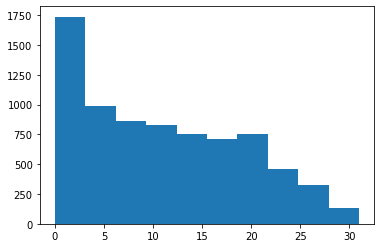

In [58]:
# Distribution of tweets in communities
comm_list = community_similarity.apply(lambda x: np.argmax(x), axis=1)
plt.hist(comm_list.values)
plt.show()

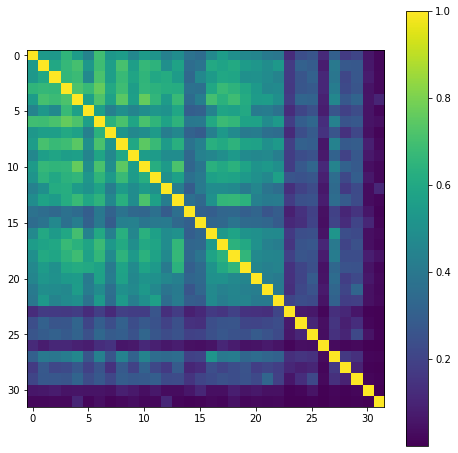

In [44]:
# Correlation matrix
fig, axs = plt.subplots(1, 1, figsize=(8,8))
axs.imshow(community_similarity.corr())
plt.colorbar(axs.imshow(community_similarity.corr()))
plt.show()